In [1]:
import pandas as pd

#with clusters
file_path = 'student8/s8.xlsx'
#file_path = 'student8/df_clustering_with_bad_quit.xlsx'
df = pd.read_excel(file_path, dtype={"outcome": str})


In [2]:
df['response_id'] = df.groupby('skill_id').cumcount() + 1

In [3]:
df["user_id"] = 8

In [4]:
df.head()

,start_time,end_time,Duration (min:sec),Score,At LC,Points,grade,session,skill,skill_level_change,...,cum_hints_day,cum_same_skill_day,same_skill_wrong,session_id,PI_score,PI_score_change,deltaPI_score_future1,deltaPI_score_past1,response_id,user_id
0,2020-08-09 14:09:53,2020-08-09 14:11:24,01:31,67.71(0.80),NaN,--,4,PROFICIENCY,G4 1.1,23.0,...,0,1,0,1,67.71,0.8,0.32,0.8,1,8
1,NaT,NaT,NaN,NaN,NaN,NaN,4,PROFICIENCY,G4 1.2,23.0,...,0,1,0,1,NaN,NaN,NaN,NaN,1,8
2,NaT,NaT,NaN,NaN,NaN,NaN,4,PROFICIENCY,G4 1.3,23.0,...,0,1,0,1,NaN,NaN,NaN,NaN,1,8
3,NaT,NaT,NaN,NaN,NaN,NaN,4,PROFICIENCY,G4 1.4,23.0,...,0,1,0,1,NaN,NaN,NaN,NaN,1,8
4,NaT,NaT,NaN,NaN,NaN,NaN,4,PROFICIENCY,G4 1.5,23.0,...,0,1,0,1,NaN,NaN,NaN,NaN,1,8


In [5]:
df = df[df['curr_resp'] != 2]


In [6]:
# pip install -U pyBKT pandas   # run once, upgrades to latest if you wish

import pandas as pd
from pyBKT.models import Model

# -------------------------------------------------------------
# 1) One-student, multi-skill event log ------------------------
#    Replace this toy DataFrame with your real data.
# -------------------------------------------------------------
df = pd.DataFrame({
    "user_id":    df['user_id'],                       #   ← single student ID
    "skill_name": df['skill'],
    "correct":    df['curr_resp'],
    "problem_id": df['response_id']                  # chronological order
})

# -------------------------------------------------------------
# 2) Fit BKT to every skill automatically ---------------------
# -------------------------------------------------------------
model = Model(seed=0, num_fits=1)
model.fit(data=df)          # no `skills=` ⇒ fit all unique skills present

# -------------------------------------------------------------
# 3) Predict for every row ------------------------------------
# -------------------------------------------------------------
pred = model.predict(data=df)

# If your pyBKT build lacks the prior column, reconstruct it.
if "state_predictions_initial" not in pred.columns:
    def add_prior(group):
        prior = model.fit_model[group.name]["prior"]
        return group["state_predictions"].shift(1).fillna(prior)

    pred["state_predictions_initial"] = (
        pred.sort_values("problem_id")          # ensure correct order
            .groupby("skill_name", group_keys=False)
            .apply(add_prior)
    )

# -------------------------------------------------------------
# 4) Show parameters for each skill ---------------------------
# -------------------------------------------------------------
import numpy as np

print("\n--- BKT parameters by skill ---")
for skill, p in model.fit_model.items():
    # helper: convert “float or 1-element array” → pure float
    to_scalar = lambda x: float(np.asarray(x).ravel()[0])

    prior = to_scalar(p["prior"])
    learn = to_scalar(p.get("learns", p.get("transit")))   # key name varies by version
    guess = to_scalar(p["guesses"])
    slip  = to_scalar(p["slips"])

    print(f"{skill:10s}  prior={prior:.3f}  "
          f"learn={learn:.3f}  guess={guess:.3f}  slip={slip:.3f}")


# -------------------------------------------------------------
# 5) Peek at predictions (first few rows) ---------------------
# -------------------------------------------------------------
cols = ["problem_id", "skill_name", "correct",
        "correct_predictions",
        "state_predictions_initial", "state_predictions"]

print("\n--- First few predictions ---")
print(pred[cols].head(12).round(3))



--- BKT parameters by skill ---
G4 1.1      prior=0.772  learn=0.888  guess=1.000  slip=0.073
G4 1.2      prior=0.994  learn=0.910  guess=1.000  slip=0.000
G4 1.3      prior=0.491  learn=0.838  guess=1.000  slip=0.000
G4 1.4      prior=0.988  learn=0.661  guess=1.000  slip=0.000
G4 1.5      prior=0.731  learn=0.507  guess=0.674  slip=0.172
G4 1.6      prior=0.936  learn=0.734  guess=1.000  slip=0.053
G4 1.7      prior=0.760  learn=0.819  guess=1.000  slip=0.000
G4 1.8      prior=0.968  learn=0.483  guess=0.997  slip=0.067
G4 1.9      prior=0.960  learn=0.484  guess=1.000  slip=0.000
G4 2.1      prior=0.990  learn=0.498  guess=0.644  slip=0.111
G4 2.2      prior=0.979  learn=0.839  guess=1.000  slip=0.000
G4 2.3      prior=0.979  learn=0.625  guess=1.000  slip=0.000
G4 2.4      prior=0.864  learn=0.650  guess=1.000  slip=0.128
G4 2.5      prior=0.990  learn=0.870  guess=1.000  slip=0.000
G4 2.6      prior=0.000  learn=0.108  guess=0.246  slip=0.002
G4 2.7      prior=0.035  learn=0.627 

/var/folders/vz/bx2mgp_54y717s2jqf8ylqf80000gn/T/ipykernel_43728/1564980820.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_prior)


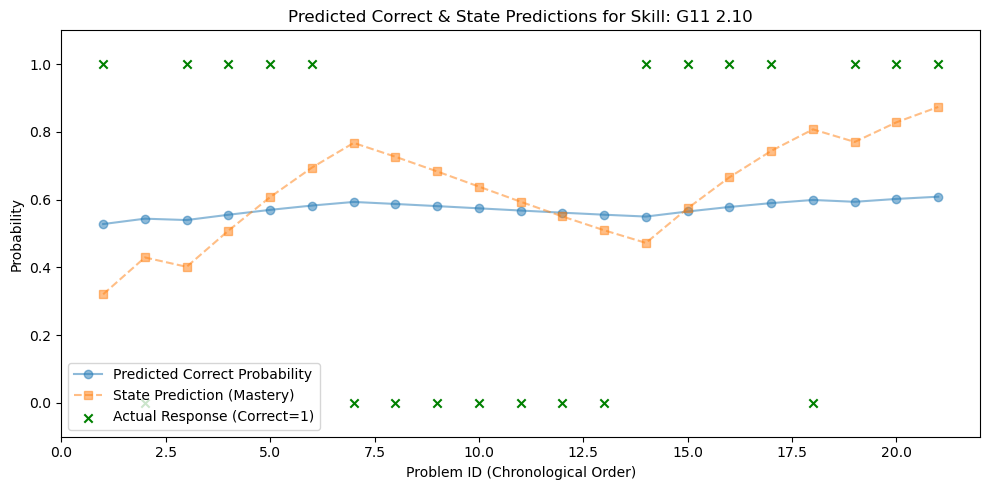

In [36]:
import matplotlib.pyplot as plt

# Filter the prediction DataFrame for skill "G7 7.5"
pred_skill = pred[pred["skill_name"] == "G11 2.10"].copy()

# Sort by problem_id to ensure chronological order
pred_skill.sort_values("problem_id", inplace=True)

# Plot predicted correct probabilities over time
plt.figure(figsize=(10, 5))
plt.plot(pred_skill["problem_id"], pred_skill["correct_predictions"],
         marker='o', linestyle='-', label='Predicted Correct Probability',alpha=0.5)

# Plot the state predictions (posterior mastery probability)
plt.plot(pred_skill["problem_id"], pred_skill["state_predictions"],
         marker='s', linestyle='--', label='State Prediction (Mastery)',alpha=0.5)

# Overlay actual response correctness for reference
plt.scatter(pred_skill["problem_id"], pred_skill["correct"],
            marker='x', color='green',label='Actual Response (Correct=1)', alpha=1)

plt.title("Predicted Correct & State Predictions for Skill: G11 2.10")
plt.xlabel("Problem ID (Chronological Order)")
plt.ylabel("Probability")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score, accuracy_score
import pandas as pd

# Get a list of unique skills
skills = pred['skill_name'].unique()

# Store metrics in a list of dicts
results = []
for skill in skills:
    df_skill = pred[pred['skill_name'] == skill]
    y_true = df_skill['correct']
    y_pred = df_skill['correct_predictions']

    if len(y_true.unique()) < 2:
        # ROC AUC is not defined when only one class present
        auc = None
    else:
        auc = roc_auc_score(y_true, y_pred)

    try:
        results.append({
            'skill': skill,
            'log_loss': log_loss(y_true, y_pred, labels=[0, 1]),
            'brier_score': brier_score_loss(y_true, y_pred),
            'auc': auc,
            'accuracy': accuracy_score(y_true, y_pred >= 0.5),
            'n': len(df_skill)
        })
    except ValueError:
        continue  # skip problematic skills (e.g., empty or all 0/1)

df_perf = pd.DataFrame(results).sort_values('log_loss')  # sort by log loss (lower = better)


In [27]:
pd.options.display.max_rows=2000
pd.set_option('display.max_columns', None)

In [28]:
df_perf

,skill,log_loss,brier_score,auc,accuracy,n,accuracy_range
862,G10 11.2,0.00000,0.00000,NaN,1.00000,8,0.9–1.0
160,G5 8.4,0.00000,0.00000,NaN,1.00000,17,0.9–1.0
622,G9 8.1,0.00000,0.00000,NaN,1.00000,9,0.9–1.0
980,G10 20.8,0.00000,0.00000,NaN,1.00000,8,0.9–1.0
167,G5 11.2,0.00000,0.00000,NaN,1.00000,14,0.9–1.0
744,G9 18.6,0.00000,0.00000,NaN,1.00000,8,0.9–1.0
900,G10 14.4,0.00000,0.00000,NaN,1.00000,8,0.9–1.0
177,G6 2.3,0.00000,0.00000,NaN,1.00000,21,0.9–1.0
901,G10 14.5,0.00000,0.00000,NaN,1.00000,8,0.9–1.0
181,G6 2.8,0.00000,0.00000,NaN,1.00000,16,0.9–1.0


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Define accuracy bins and labels
bins = [0.0, 0.5, 0.7, 0.8, 0.9, 1.0]
labels = ['0–0.5', '0.5–0.7', '0.7–0.8', '0.8–0.9', '0.9–1.0']

# Bin the accuracy values
df_perf['accuracy_range'] = pd.cut(df_perf['accuracy'], bins=bins, labels=labels, include_lowest=True)

# Count number of skills in each range
count_df = df_perf['accuracy_range'].value_counts().sort_index().reset_index()
count_df.columns = ['accuracy_range', 'count_skills']


count_df

,accuracy_range,count_skills
0,0–0.5,0
1,0.5–0.7,66
2,0.7–0.8,197
3,0.8–0.9,318
4,0.9–1.0,440


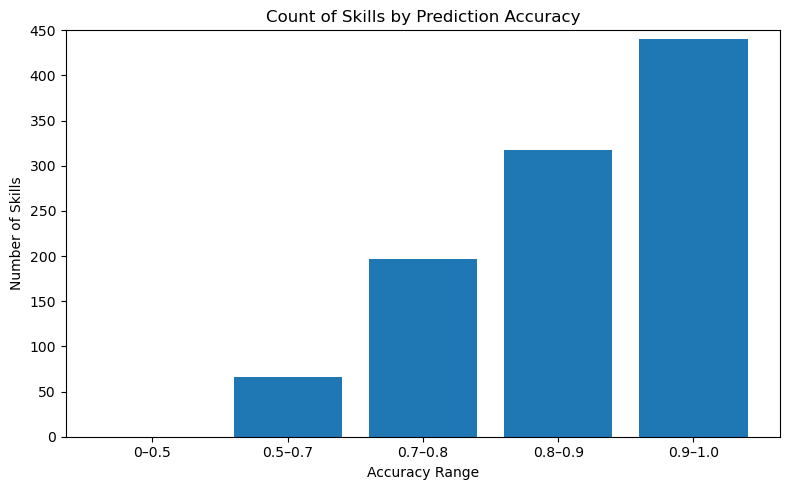

In [26]:
plt.figure(figsize=(8, 5))
plt.bar(count_df['accuracy_range'], count_df['count_skills'])
plt.xlabel('Accuracy Range')
plt.ylabel('Number of Skills')
plt.title('Count of Skills by Prediction Accuracy')
plt.ylim(0, count_df['count_skills'].max() + 10)
plt.tight_layout()
plt.show()